In [166]:
import torch
import pickle
import einops
import importlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
from matplotlib.colors import Normalize
from typing import Callable
import json

import circuits.analysis as analysis
import circuits.eval_sae_as_classifier as eval_sae
import circuits.chess_utils as chess_utils
import circuits.utils as utils
import circuits.f1_analysis as f1_analysis

I've been trying to balance: Having a notebook that's easy to play around with, but also modularizing code into files, and not having duplicated functions between notebooks and python files that goes stale.

Here's what I'm trying: All of the following functions in the next few cells are also in `f1_analysis.py`. By default, this notebook just loads a `f1_results.csv` from the autoencoder group path, automatically generated during `full_pipeline.ipynb`. If you want to play around with new analysis functions, feel free to uncomment the lines that call these functions, modify the below functions, and experiment to your heart's content.

In [167]:
def mask_all_blanks(results: dict, device) -> dict:
    custom_functions = analysis.get_all_custom_functions(results)
    for function in custom_functions:
        function_name = function.__name__

        if function == chess_utils.board_to_piece_state or function == chess_utils.board_to_piece_color_state:
            on_TFRRC = results[function_name]['on']
            off_TFRRC = results[function_name]['off']
            results[function_name]['on'] = analysis.mask_initial_board_state(on_TFRRC, function, device)
            results[function_name]['off'] = analysis.mask_initial_board_state(off_TFRRC, function, device)

    return results

def best_f1_average(f1_TFRRC: torch.Tensor, config: chess_utils.Config) -> torch.Tensor:
    """For every threshold, for every square, find the best F1 score across all features. Then average across all squares.
    NOTE: If the function is binary, num_squares == 1. If it is board to piece state, num_squares == 8 * 8 * 12"""
    f1_TRRC, _ = torch.max(f1_TFRRC, dim=1)

    T, R1, R2, C = f1_TRRC.shape

    if config.one_hot_mask_idx is not None:
        C -= 1

    max_possible = R1 * R2 * C

    f1_T = einops.reduce(f1_TRRC, 'T R1 R2 C -> T', 'sum') / max_possible

    return f1_T
    

def f1s_above_threshold(f1_TFRRC: torch.Tensor, threshold: float, config: chess_utils.Config) -> tuple[torch.Tensor, torch.Tensor]:
    """For every threshold, for every square, find the best F1 score across all features. Then, find the number of squares that have a F1 score above the threshold.
    If the function is binary, num_squares == 1. If it is board to piece state, num_squares == 8 * 8 * 12
    NOTE: This will probably be most useful for features with 8x8xn options."""
    f1_TRRC, _ = torch.max(f1_TFRRC, dim=1)

    f1s_above_threshold_TRCC = f1_TRRC > threshold

    T, R1, R2, C = f1_TRRC.shape
    if config.one_hot_mask_idx is not None:
        C -= 1

    max_possible = R1 * R2 * C

    f1_T = einops.reduce(f1s_above_threshold_TRCC, 'T R1 R2 C -> T', 'sum')

    f1_T_normalized = f1_T / max_possible

    return f1_T, f1_T_normalized


In [168]:
importlib.reload(analysis)


def get_custom_functions(
    autoencoder_group_path: str, results_filename_filter: str, device: str
) -> list[Callable]:
    folders = eval_sae.get_nested_folders(autoencoder_group_path)
    first_autoencoder_path = folders[0]
    results_filenames = analysis.get_all_results_file_names(
        first_autoencoder_path, results_filename_filter
    )

    if len(results_filenames) > 1 or len(results_filenames) == 0:
        raise ValueError("There are multiple results files")
    results_filename = results_filenames[0]

    with open(first_autoencoder_path + results_filename, "rb") as f:
        results = pickle.load(f)

    results = utils.to_device(results, device)

    custom_functions = analysis.get_all_custom_functions(results)
    return custom_functions


def get_custom_function_names(custom_functions: list[Callable]) -> list[str]:
    custom_function_names = [function.__name__ for function in custom_functions]
    return custom_function_names

def get_threshold_column_names(func_name: str, threshold: float) -> tuple[str, str]:
    return (f"{func_name}_f1_threshold_{threshold}", f"{func_name}_f1_threshold_{threshold}_normalized")


def get_all_sae_f1_results(
    autoencoder_group_paths: list[str],
    df: pd.DataFrame,
    results_filename_filter: str,
    custom_functions: list[Callable],
    custom_function_names: list[str],
    device: str,
    thresholds: list[float],
    mask: bool,
) -> dict:
    all_sae_results = {}

    for autoencoder_group_path in autoencoder_group_paths:

        folders = eval_sae.get_nested_folders(autoencoder_group_path)
        sae_results = {}

        for autoencoder_path in folders:

            print(f"Processing {autoencoder_path}")

            assert (
                autoencoder_path in df["autoencoder_path"].values
            ), f"{autoencoder_path} not in csv file"

            sae_results[autoencoder_path] = {}

            results_filenames = analysis.get_all_results_file_names(
                autoencoder_path, results_filename_filter
            )
            if len(results_filenames) > 1 or len(results_filenames) == 0:
                print(
                    f"Skipping {autoencoder_path} because it has {len(results_filenames)} results files"
                )
                print("This is most likely because there are results files from different n_inputs")
                continue
            results_filename = results_filenames[0]

            with open(autoencoder_path + results_filename, "rb") as f:
                results = pickle.load(f)

            results = utils.to_device(results, device)

            results = analysis.add_off_tracker(results, custom_functions, device)
            f1_dict_TFRRC = analysis.get_all_f1s(results, device)

            # feature_labels = analysis.analyze_results_dict(
            #     results,
            #     output_path="",
            #     device=device,
            #     high_threshold=0.95,
            #     low_threshold=0.1,
            #     significance_threshold=10,
            #     save_results=False,
            #     mask=mask,
            #     verbose=False,
            #     print_results=False,
            # )

            correct_row = df["autoencoder_path"] == autoencoder_path
            sae_results[autoencoder_path]["l0"] = df[correct_row]["l0"].values[0]
            sae_results[autoencoder_path]["frac_variance_explained"] = df[correct_row][
                "frac_variance_explained"
            ].values[0]

            for func_name in f1_dict_TFRRC:
                config = chess_utils.config_lookup[func_name]
                custom_function = config.custom_board_state_function
                assert (
                    custom_function in custom_functions
                ), f"Key {custom_function} not in custom_functions"
                f1_TFRRC = f1_dict_TFRRC[func_name]

                average_f1_T = best_f1_average(f1_TFRRC, config)
                sae_results[autoencoder_path][f"{func_name}_average_f1"] = average_f1_T

                for threshold in thresholds:
                    threshold_column, threshold_column_normalized = get_threshold_column_names(
                        func_name, threshold
                    )
                    f1_T, f1_T_normalized = f1s_above_threshold(f1_TFRRC, threshold, config)
                    sae_results[autoencoder_path][threshold_column] = f1_T
                    sae_results[autoencoder_path][threshold_column_normalized] = f1_T_normalized

            # torch.cuda.empty_cache()
        all_sae_results[autoencoder_group_path] = sae_results
    return all_sae_results

def update_dataframe_with_results(df, all_sae_results, custom_function_names, autoencoder_group_paths, thresholds):
    assert df['autoencoder_path'].is_unique
    updates = []
    for autoencoder_group_path in autoencoder_group_paths:
        folders = eval_sae.get_nested_folders(autoencoder_group_path)
        for autoencoder_path in folders:
            results = {'autoencoder_path': autoencoder_path}
            for func_name in custom_function_names:
        
                f1_T = all_sae_results[autoencoder_group_path][autoencoder_path][f"{func_name}_average_f1"]
                best_idx = torch.argmax(f1_T)
                best_f1 = f1_T[best_idx]
                
                results[f"{func_name}_best_average_f1"] = best_f1.item()
                results[f"{func_name}_best_average_f1_idx"] = best_idx.item()
                results[f"{func_name}_all_average_f1s"] = json.dumps(f1_T.tolist())

                for threshold in thresholds:
                    threshold_column, threshold_normalized_column = get_threshold_column_names(func_name, threshold)
                    f1_T = all_sae_results[autoencoder_group_path][autoencoder_path][threshold_column]
                    f1_T_normalized = all_sae_results[autoencoder_group_path][autoencoder_path][threshold_normalized_column]
                    best_idx = torch.argmax(f1_T)
                    best_f1_at_threshold = f1_T[best_idx]
                    best_f1_normalized = f1_T_normalized[best_idx]
                    
                    results[f"{func_name}_f1_threshold_{threshold}_best"] = best_f1_at_threshold.item()
                    results[f"{func_name}_f1_threshold_{threshold}_best_normalized"] = best_f1_normalized.item()
                    results[f"{func_name}_f1_threshold_{threshold}_best_idx"] = best_idx.item()
                    results[f"{func_name}_f1_threshold_{threshold}_best_normalized_idx"] = best_idx.item()
                    results[f"{func_name}_f1_threshold_{threshold}_all"] = json.dumps(f1_T.tolist())
                    results[f"{func_name}_f1_threshold_{threshold}_all_normalized"] = json.dumps(f1_T_normalized.tolist())

            
            updates.append(results)

    update_df = pd.DataFrame(updates)
    df = pd.merge(df, update_df, on='autoencoder_path', how='outer')
    assert df['autoencoder_path'].is_unique
    return df




Set autoencoder group paths and thresholds here.

In [169]:
import pandas as pd

device = "cpu"
# device = "cuda"
# mask = False
# thresholds = torch.arange(0.1, 1, 0.1)

# autoencoder_group_paths = ["../autoencoders/chess_layer5_large_sweep/"]
# autoencoder_group_paths = ["../autoencoders/group-2024-05-14_chess/"]
# autoencoder_group_paths = ["../autoencoders/group-2024-05-14_chess/"]
# # autoencoder_group_paths = ["../autoencoders/chess_layer0/"]

# csv_results_file = "../autoencoders/chess_layer5_large_sweep/results.csv"
# # csv_results_file = "../autoencoders/chess_layer0/results.csv"
# csv_results_file = "../autoencoders/group-2024-05-14_chess/results.csv"
# output_path = csv_results_file.replace(".csv", "_f1_results.csv")


# results_filename_filter = (
#     "1000"  # This is only necessary if you have multiple files with multiple n_inputs
# )
# e.g. indexing_find_dots_indices_n_inputs_1000_results.pkl and indexing_find_dots_indices_n_inputs_5000_results.pkl
# In this case, if you want to view the results for n_inputs = 1000, you would set filter = "1000"

# custom_functions = get_custom_functions(autoencoder_group_paths[0], results_filename_filter, device)
# custom_function_names = get_custom_function_names(custom_functions)
# all_sae_results = get_all_sae_f1_results(autoencoder_group_paths, df, results_filename_filter, custom_functions, custom_function_names, device, thresholds, mask)

# df = pd.read_csv(csv_results_file)
# df = update_dataframe_with_results(df, all_sae_results, custom_function_names, autoencoder_group_paths, thresholds)
# df.to_csv(output_path, index=False)

# output_path = f1_analysis.complete_analysis_pipeline(autoencoder_group_paths, csv_results_file, results_filename_filter, device, thresholds)


In [170]:
output_path = "../autoencoders/group-2024-05-14_chess/chess_5_23_f1_results.csv"
output_path = "../autoencoders/othello_5-21/othello_f1_results.csv"
output_path = "../autoencoders/othello_f1_results_5-26.csv"
# output_path = "../autoencoders/chess_f1_results_5-25_v2.csv"
# output_path = "../autoencoders/othello_layer0/f1_results.csv"
df = pd.read_csv(output_path)
def convert_json(x):
    try:
        return json.loads(x)  # Attempt to parse JSON
    except (ValueError, TypeError):
        return x  # Return the original value if it's not a JSON string

def convert_dataframe(df):
    # Apply the conversion function to each element in the DataFrame
    return df.map(convert_json)
df = convert_dataframe(df)

In [171]:

othello = f1_analysis.check_df_if_othello(df)
print(f"Is this Othello? {othello}")

Is this Othello? True


In [172]:
for col in df.columns:
    print(col)

Unnamed: 0
autoencoder_group_path
autoencoder_path
reconstruction_file
trainer_class
sae_class
eval_sae_n_inputs
eval_results_n_inputs
board_reconstruction_n_inputs
l0
l1_loss
l2_loss
frac_alive
frac_variance_explained
cossim
l2_ratio
loss_original
loss_reconstructed
loss_zero
frac_recovered
num_alive_features
games_batch_to_state_stack_mine_yours_BLRRC_board_reconstruction_board_count
games_batch_to_state_stack_mine_yours_BLRRC_num_squares
games_batch_to_state_stack_mine_yours_BLRRC_best_idx
games_batch_to_state_stack_mine_yours_BLRRC_zero_L0
games_batch_to_state_stack_mine_yours_BLRRC_best_L0
games_batch_to_state_stack_mine_yours_BLRRC_zero_f1_score_per_class
games_batch_to_state_stack_mine_yours_BLRRC_best_f1_score_per_class
games_batch_to_state_stack_mine_yours_BLRRC_zero_f1_score_per_square
games_batch_to_state_stack_mine_yours_BLRRC_best_f1_score_per_square
games_batch_to_state_stack_mine_yours_BLRRC_zero_num_true_positive_squares
games_batch_to_state_stack_mine_yours_BLRRC_best_

The following coverage metric is "for best f1 feature per board state property, is the f1 above `desired_threshold`?

In [159]:
coverage_threshold_columns = []
coverage_threshold_idx_columns = []
desired_threshold = 0.8
for col in df.columns:
    if f"f1_threshold_{desired_threshold}_best_normalized" in col and "idx" not in col:
        coverage_threshold_columns.append(col)
        print(col)
    if f"f1_threshold_{desired_threshold}_best_normalized_idx" in col:
        coverage_threshold_idx_columns.append(col)

games_batch_to_state_stack_mine_yours_BLRRC_f1_threshold_0.8_best_normalized
games_batch_to_state_stack_mine_yours_blank_mask_BLRRC_f1_threshold_0.8_best_normalized
games_batch_to_valid_moves_BLRRC_f1_threshold_0.8_best_normalized


This is coverage with average f1.

In [187]:


average_coverage_columns = []
average_coverage_idx_columns = []

average_coverage_key = "best_average_f1"

for col in df.columns: 
    if average_coverage_key in col and "idx" not in col:
        average_coverage_columns.append(col)
        print(col)
    if f"{average_coverage_key}_idx" in col:
        average_coverage_idx_columns.append(col)
        print(col)

games_batch_to_state_stack_mine_yours_BLRRC_best_average_f1
games_batch_to_state_stack_mine_yours_BLRRC_best_average_f1_idx
games_batch_to_state_stack_mine_yours_blank_mask_BLRRC_best_average_f1
games_batch_to_state_stack_mine_yours_blank_mask_BLRRC_best_average_f1_idx
games_batch_to_valid_moves_BLRRC_best_average_f1
games_batch_to_valid_moves_BLRRC_best_average_f1_idx


This is board reconstruction.

In [161]:
board_reconstruction_columns = []
board_reconstruction_idx_columns = []

board_reconstruction_key = "best_f1_score_per_class"

for col in df.columns:
    if board_reconstruction_key in col and "idx" not in col:
        board_reconstruction_columns.append(col)
        print(col)
        f1_idx = col.replace(board_reconstruction_key, "best_idx")
        board_reconstruction_idx_columns.append(f1_idx)

games_batch_to_state_stack_mine_yours_BLRRC_best_f1_score_per_class
games_batch_to_state_stack_mine_yours_blank_mask_BLRRC_best_f1_score_per_class
games_batch_to_valid_moves_BLRRC_best_f1_score_per_class


Use the next cell if you are checking out cosine similarity.

In [162]:
# cos_sim_columns = []

# for col in df.columns:
#     if "cos_sim" in col:
#         cos_sim_columns.append(col)
#         print(col)

The next 2 cells find the average f1 score and custom metric score for all functions, all 8x8 board state functions, and all binary functions, then store it in the df and `average_metric_columns` and `average_metric_idx_columns`. It's pretty verbose, but it works.

In [193]:
board_state_8x8_columns = [
    "board_to_piece_state",
    "board_to_piece_color_state",
    "board_to_threat_state",
    "board_to_legal_moves_state",
    "board_to_pseudo_legal_moves_state",
]

paper_average_columns = []
paper_average_idx_columns = []

othello_low_level_columns = [
    ("games_batch_to_state_stack_mine_yours_blank_mask_BLRRC", 2.0),
    ("games_batch_to_valid_moves_BLRRC", 1.0),
]

df, paper_average_columns, paper_average_idx_columns = f1_analysis.add_average_board_reconstruction_for_columns(
    df,
    paper_average_columns,
    paper_average_idx_columns,
    othello_low_level_columns,
    "low_level_",
    board_reconstruction_key,
)

df, paper_average_columns, paper_average_idx_columns = f1_analysis.add_average_coverage_for_columns(
    df,
    paper_average_columns,
    paper_average_idx_columns,
    othello_low_level_columns,
    "low_level_",
    average_coverage_key,
)


# def get_board_state_columns(
#     board_state_columns: list[str], columns: list[str], include: bool = True
# ) -> list[str]:
#     result_columns = []
#     for col in columns:
#         if any([board_state in col for board_state in board_state_columns]):
#             if include:
#                 result_columns.append(col)
#         else:
#             if not include:
#                 result_columns.append(col)
#     return result_columns


# best_columns = get_board_state_columns(
#     board_state_8x8_columns, best_f1_columns, include=True
# )
# best_f1_board_state_idx_columns = get_board_state_columns(
#     board_state_8x8_columns, best_f1_idx_columns, include=True
# )

# best_custom_metric_board_state_columns = get_board_state_columns(
#     board_state_8x8_columns, custom_metric_columns, include=True
# )
# best_custom_metric_board_state_idx_columns = get_board_state_columns(
#     board_state_8x8_columns, custom_metric_idx_columns, include=True
# )

# best_f1_binary_columns = get_board_state_columns(
#     board_state_8x8_columns, best_f1_columns, include=False
# )
# best_f1_binary_idx_columns = get_board_state_columns(
#     board_state_8x8_columns, best_f1_idx_columns, include=False
# )

# best_custom_metric_binary_columns = get_board_state_columns(
#     board_state_8x8_columns, custom_metric_columns, include=False
# )
# best_custom_metric_binary_idx_columns = get_board_state_columns(
#     board_state_8x8_columns, custom_metric_idx_columns, include=False
# )

In [195]:
print(paper_average_columns)
print(paper_average_idx_columns)

['average_low_level_best_f1_score_per_class_f1', 'average_low_level_best_average_f1']
['average_low_level_best_f1_score_per_class_best_idx', 'average_low_level_best_average_f1_best_idx']


In [177]:
# def add_average_metric_over_functions(
#     df: pd.DataFrame,
#     metric_type: str,
#     average_metric_columns: list[str],
#     average_metric_idx_columns: list[str],
#     custom_metric_columns: list[str],
#     custom_metric_idx_columns: list[str],
# ) -> tuple[pd.DataFrame, list[str], list[str]]:

#     average_metric_column = f"{metric_type}_average"
#     average_metric_idx_column = f"{metric_type}_average_idx"

#     average_metric_columns.append(average_metric_column)
#     average_metric_idx_columns.append(average_metric_idx_column)

#     df[average_metric_column] = np.nan
#     df[average_metric_idx_column] = np.nan

#     df[average_metric_column] = df[custom_metric_columns].mean(axis=1)
#     df[average_metric_idx_column] = df[custom_metric_idx_columns].mean(axis=1)

#     return df, average_metric_columns, average_metric_idx_columns


# average_metric_columns = []
# average_metric_idx_columns = []

# df, average_metric_columns, average_metric_idx_columns = add_average_metric_over_functions(
#     df,
#     "best_f1_score_per_square",
#     average_metric_columns,
#     average_metric_idx_columns,
#     best_f1_board_state_columns,
#     best_f1_board_state_idx_columns,
# )
# df, average_metric_columns, average_metric_idx_columns = add_average_metric_over_functions(
#     df,
#     "best_custom_metric",
#     average_metric_columns,
#     average_metric_idx_columns,
#     best_custom_metric_board_state_columns,
#     best_custom_metric_board_state_idx_columns,
# )
# df, average_metric_columns, average_metric_idx_columns = add_average_metric_over_functions(
#     df,
#     "best_f1_score_per_square_only_board_state",
#     average_metric_columns,
#     average_metric_idx_columns,
#     best_f1_board_state_columns,
#     best_f1_board_state_idx_columns,
# )
# df, average_metric_columns, average_metric_idx_columns = add_average_metric_over_functions(
#     df,
#     "best_custom_metric_only_board_state",
#     average_metric_columns,
#     average_metric_idx_columns,
#     best_custom_metric_board_state_columns,
#     best_custom_metric_board_state_idx_columns,
# )
# df, average_metric_columns, average_metric_idx_columns = add_average_metric_over_functions(
#     df,
#     "best_f1_score_per_square_only_binary",
#     average_metric_columns,
#     average_metric_idx_columns,
#     best_f1_binary_columns,
#     best_f1_binary_idx_columns,
# )
# df, average_metric_columns, average_metric_idx_columns = add_average_metric_over_functions(
#     df,
#     "best_custom_metric_only_binary",
#     average_metric_columns,
#     average_metric_idx_columns,
#     best_custom_metric_binary_columns,
#     best_custom_metric_binary_idx_columns,
# )

In [122]:
# df
# df.to_csv("processed_results.csv", index=False)

In [123]:
# # select only the numerical columns
# numerical_columns = df.select_dtypes(include=['float64', 'int64']).columns
# numerical_data = df[numerical_columns]

# # calculate the correlation matrix
# correlation_matrix = numerical_data.corr()

# # create a heatmap using plotly
# fig = px.imshow(correlation_matrix, 
#                 labels=dict(x="Columns", y="Columns", color="Correlation"),
#                 x=correlation_matrix.columns,
#                 y=correlation_matrix.columns,
#                 color_continuous_scale='RdBu_r',
#                 zmin=-1, zmax=1)

# # update the layout
# fig.update_layout(
#     title='Correlation Matrix',
#     width=2000,
#     height=2000
# )

# # display the plot
# fig.show()

Here are all the new custom metric columns.

In [124]:
if othello:
    key = 'games_batch_to_state_stack_mine_yours_BLRRC_best_f1_score_per_square'
    key = 'games_batch_to_state_stack_mine_yours_BLRRC_best_average_f1'
else:
    key = "board_to_piece_masked_blank_and_initial_state_best_f1_score_per_square"
    key = "board_to_piece_masked_blank_and_initial_state_best_average_f1"
# key = 'games_batch_to_valid_moves_BLRRC_best_f1_score_per_square'
# Sort the DataFrame by the specified column in descending order and select the top 5
top_five_values = df.sort_values(by=key, ascending=False).head(10)

# Display only the column of interest from the top 5 rows
print(top_five_values[key])
print(top_five_values["autoencoder_path"])
print(top_five_values["trainer_class"])

97     0.408615
96     0.402440
98     0.401735
99     0.386836
16     0.386824
18     0.386564
73     0.385988
95     0.382180
100    0.382129
17     0.382106
Name: board_to_piece_masked_blank_and_initial_state_best_average_f1, dtype: float64
97     ../autoencoders/chess-trained_model-layer_5-20...
96     ../autoencoders/chess-trained_model-layer_5-20...
98     ../autoencoders/chess-trained_model-layer_5-20...
99     ../autoencoders/chess-trained_model-layer_5-20...
16     ../autoencoders/chess-trained_model-layer_5-20...
18     ../autoencoders/chess-trained_model-layer_5-20...
73     ../autoencoders/chess-trained_model-layer_5-20...
95     ../autoencoders/chess-trained_model-layer_5-20...
100    ../autoencoders/chess-trained_model-layer_5-20...
17     ../autoencoders/chess-trained_model-layer_5-20...
Name: autoencoder_path, dtype: object
97         PAnnealTrainer
96         PAnnealTrainer
98         PAnnealTrainer
99         PAnnealTrainer
16        GatedSAETrainer
18        GatedSAE

In [125]:
# for col in average_metric_columns:
#     print(col)
# for col in average_metric_idx_columns:
#     print(col)

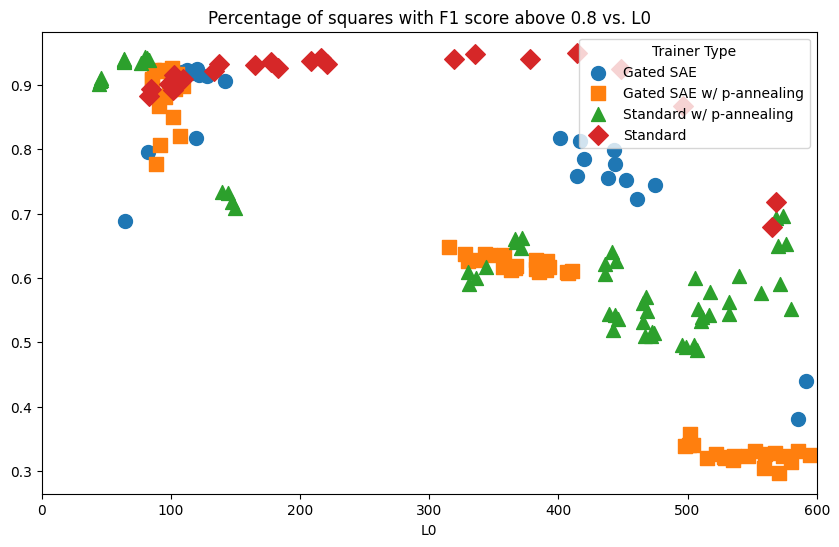

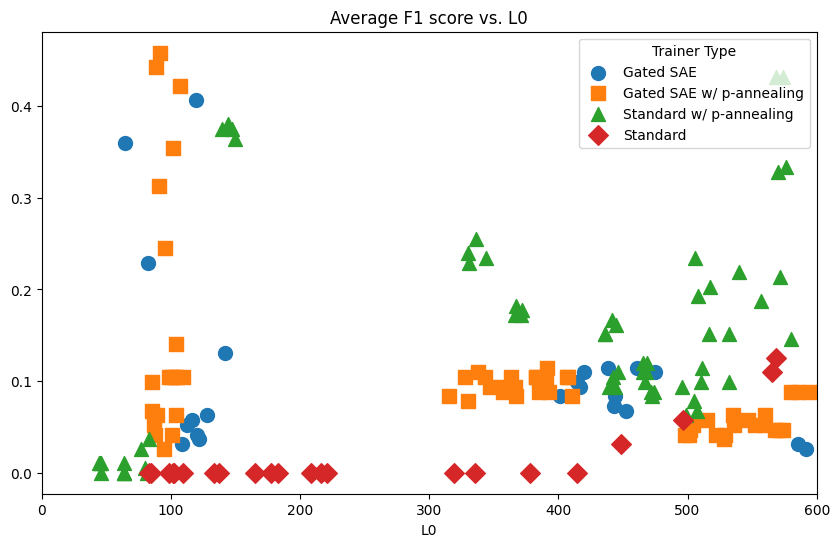

In [178]:
from typing import Optional
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

# get unique trainer types
unique_trainers = df["trainer_class"].unique()

# create a dictionary mapping trainer types to marker shapes
trainer_markers = dict(zip(unique_trainers, ["o", "s", "^", "D"]))
# “Gated SAE”, “Gated SAE w/ p-annealing”, “Standard”, “Standard w/ p-annealing”
label_lookup = {
    "GatedSAETrainer": "Gated SAE",
    "GatedAnnealTrainer": "Gated SAE w/ p-annealing",
    "StandardTrainer": "Standard",
    "PAnnealTrainer": "Standard w/ p-annealing",
}

def plot_l0_metric(column_name: str, full_title: Optional[str] = None):
    # Create the scatter plot
    fig, ax = plt.subplots(figsize=(10, 6))

    # Example data loading and processing code here
    # Assuming df is your DataFrame and it's already defined/imported

    metric_1 = "l0"
    idx = df[column_name].values[0]  # Example of accessing a DataFrame

    # Plot data points for each trainer type separately
    for trainer, marker in trainer_markers.items():
        trainer_data = df[df["trainer_class"].str.contains(trainer)]
        ax.scatter(
            trainer_data[metric_1], trainer_data[column_name], marker=marker, s=100, label=label_lookup[trainer]
        )

    # Set labels and title
    ax.set_xlabel("L0")
    ax.set_ylabel("")
    if full_title:
        ax.set_title(full_title)
    else:
        ax.set_title(f"{metric_1} vs. at threshold {idx} for {column_name}")

    # # Draw a red dashed line
    # red_line = ax.axhline(y=0.99, color="red", linestyle="--", linewidth=2)

    # # Add the red dashed line to the legend
    # red_proxy = mlines.Line2D([], [], color='red', linestyle='--', linewidth=2, label='Linear probe baseline')
    handles, labels = ax.get_legend_handles_labels()
    # handles.append(red_proxy)  # add the red line as a handle for the legend

    # Display the legend
    ax.legend(handles=handles, title="Trainer Type", loc="upper right")

    # Set x and y range
    ax.set_xlim(0, 600)
    # ax.set_ylim(0.0, )

    # Display the plot
    plt.show()

if othello:
    graph1_column_name = "games_batch_to_state_stack_mine_yours_BLRRC_best_f1_score_per_square"
    graph2_column_name = "games_batch_to_state_stack_mine_yours_BLRRC_f1_threshold_0.8_best_normalized"
else:
    graph1_column_name = "board_to_piece_masked_blank_and_initial_state_best_f1_score_per_square"
    graph2_column_name = "board_to_piece_masked_blank_and_initial_state_best_average_f1"
# graph1_column_name = "board_to_piece_masked_blank_state_best_f1_score_per_square"
# graph1_column_name = "board_to_piece_masked_blank_and_initial_state_best_average_f1"
# graph1_column_name = "board_to_piece_masked_blank_state_best_average_f1"
# graph1_column_name = "board_to_piece_masked_blank_and_initial_state_f1_threshold_0.8_best_normalized"

plot_l0_metric(graph1_column_name, full_title="Percentage of squares with F1 score above 0.8 vs. L0")
plot_l0_metric(graph2_column_name, full_title="Average F1 score vs. L0")
# plot_l0_metric(cos_sim_columns[0], full_title="Cosine similarity vs. L0")


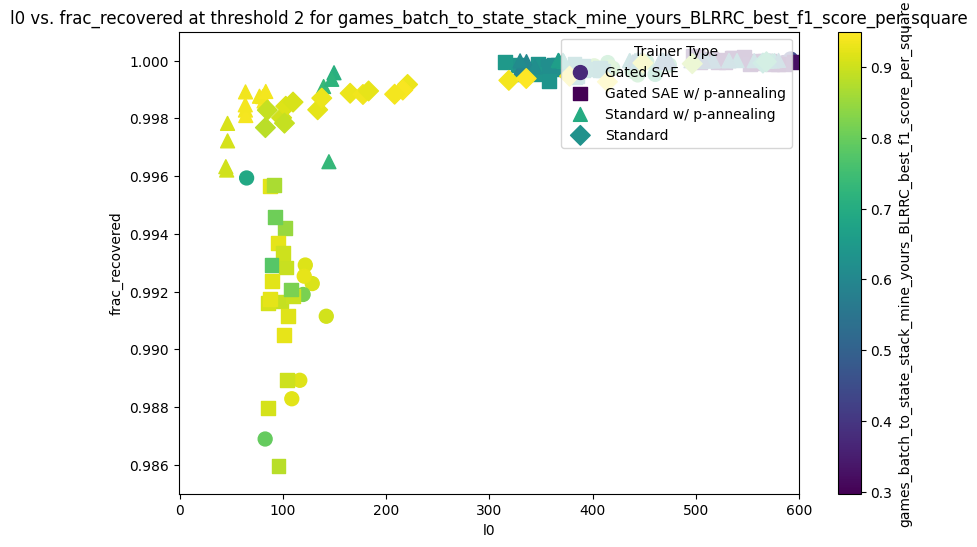

In [179]:

def plot_3var_graph(color_column: str, idx_column_name: str, full_title: Optional[str] = None):
    # create the scatter plot
    fig, ax = plt.subplots(figsize=(10, 6))

    # create a normalize object for color scaling
    # color_column = 'board_to_can_capture_queen_best_custom_metric'
    # color_column = 'board_to_piece_state_best_custom_metric'
    # color_column = 'board_to_has_legal_en_passant_best_custom_metric'
    # color_column = 'board_to_pin_state_best_custom_metric'
    # color_column = custom_metric_columns[6]
    norm = Normalize(vmin=df[color_column].min(), vmax=df[color_column].max())

    metric_1 = "l0"
    metric_2 = "frac_recovered"

    idx = df[idx_column_name].values[0]

    # plot data points for each trainer type separately
    for trainer, marker in trainer_markers.items():
        trainer_data = df[df['trainer_class'].str.contains(trainer)]
        ax.scatter(trainer_data[metric_1], trainer_data[metric_2], c=trainer_data[color_column], cmap='viridis', marker=marker, s=100, label=label_lookup[trainer], norm=norm)

    # add colorbar
    cbar = fig.colorbar(ax.collections[0], ax=ax)
    cbar.set_label(color_column)

    # set labels and title
    ax.set_xlabel(metric_1)
    ax.set_ylabel(metric_2)
    if full_title is not None:
        ax.set_title(full_title)
    else:
        ax.set_title(f'{metric_1} vs. {metric_2} at threshold {idx} for {color_column}')

    # addnd
    ax.legend(title='Trainer Type', loc='upper right')

    # # set x range
    ax.set_xlim(-1, 600)
    # ax.set_ylim(0.990, 1.001)
    ax.set_ylim(0.985, 1.001)

    # display the plot
    plt.show()

if othello:
    graph1_column_name = "games_batch_to_state_stack_mine_yours_BLRRC_best_f1_score_per_square"
else:
    graph1_column_name = "board_to_piece_masked_blank_and_initial_state_best_f1_score_per_square"

idx_column_name = graph1_column_name.replace("f1_score_per_square", "idx")

plot_3var_graph(graph1_column_name, idx_column_name)

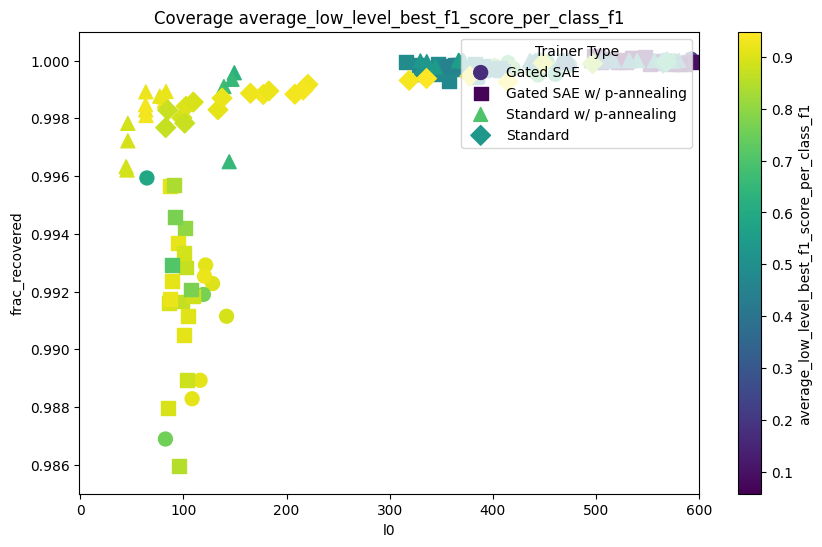

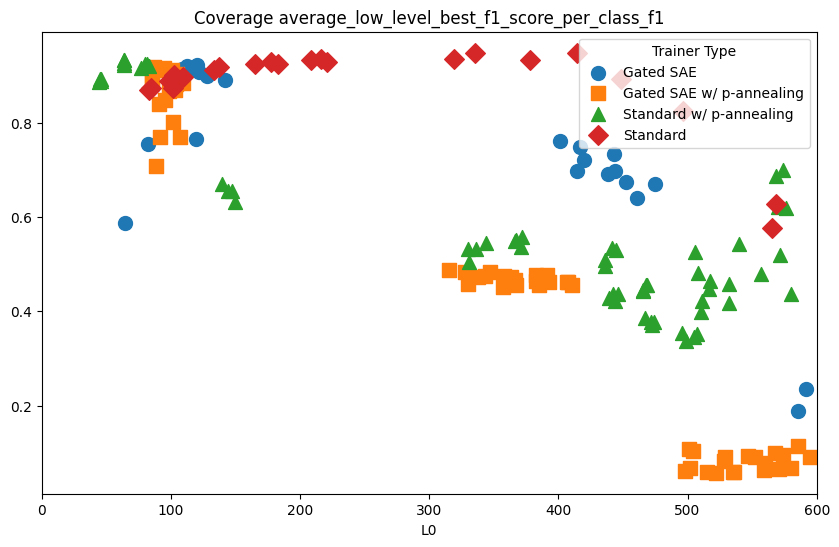

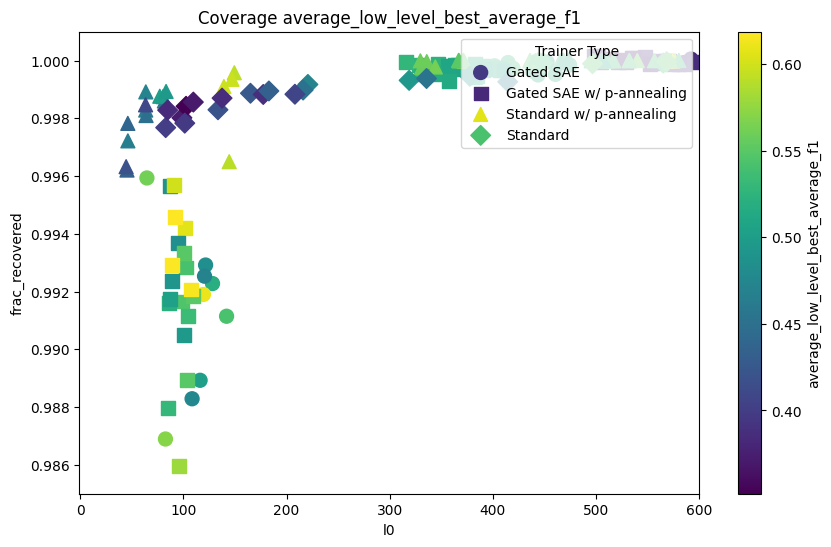

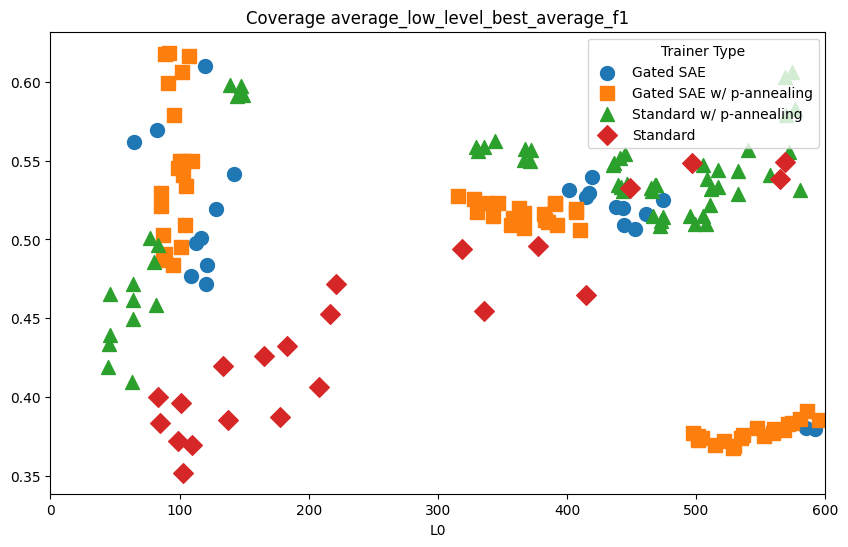

In [196]:
for i, column_name in enumerate(paper_average_columns):
    idx_column_name = paper_average_idx_columns[i]
    plot_3var_graph(column_name, idx_column_name, full_title=f"Coverage {column_name}")
    plot_l0_metric(column_name, full_title=f"Coverage {column_name}")

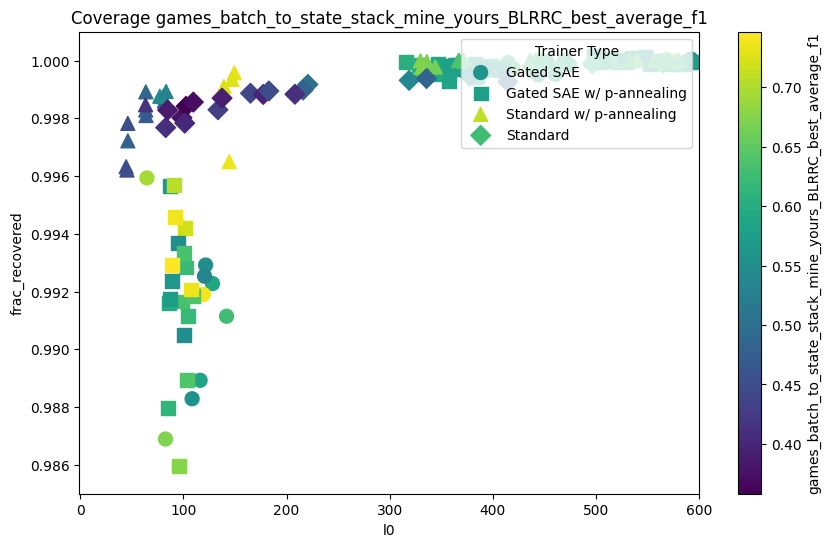

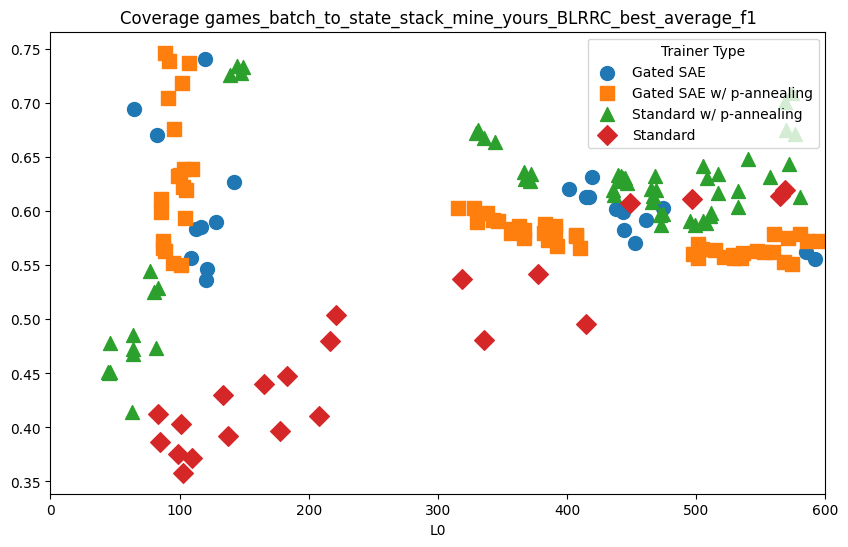

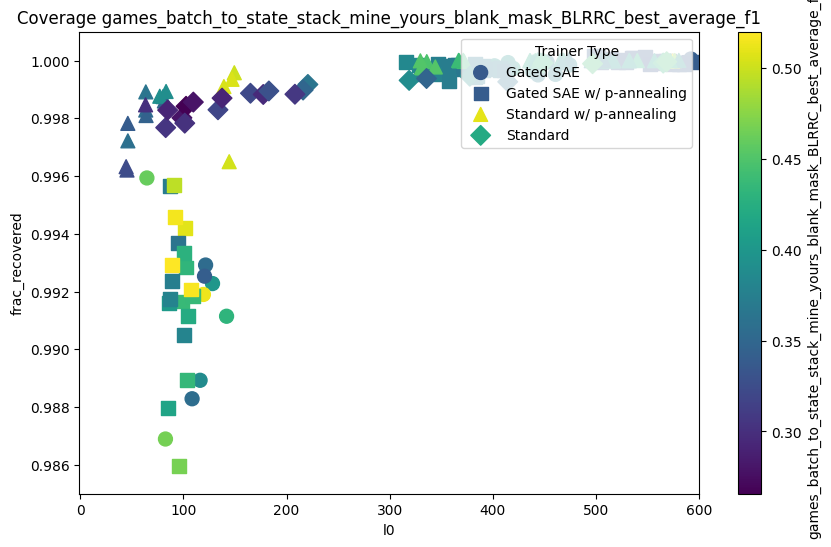

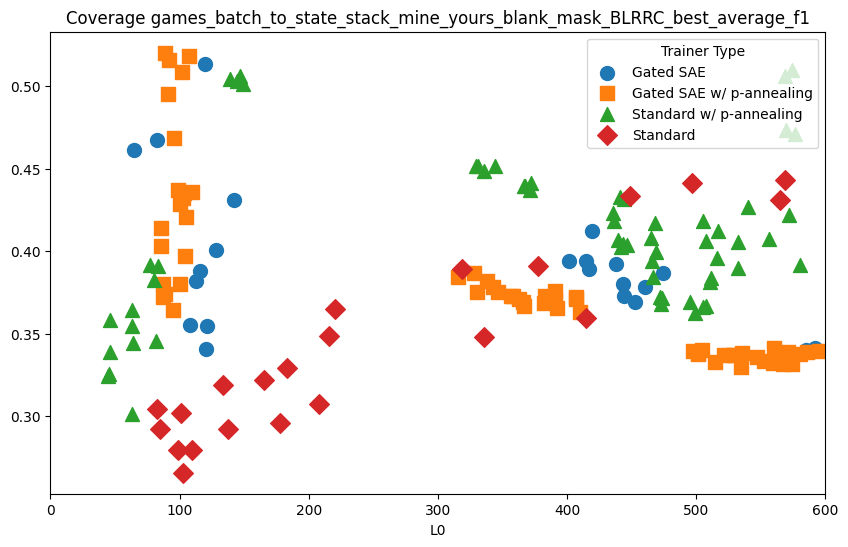

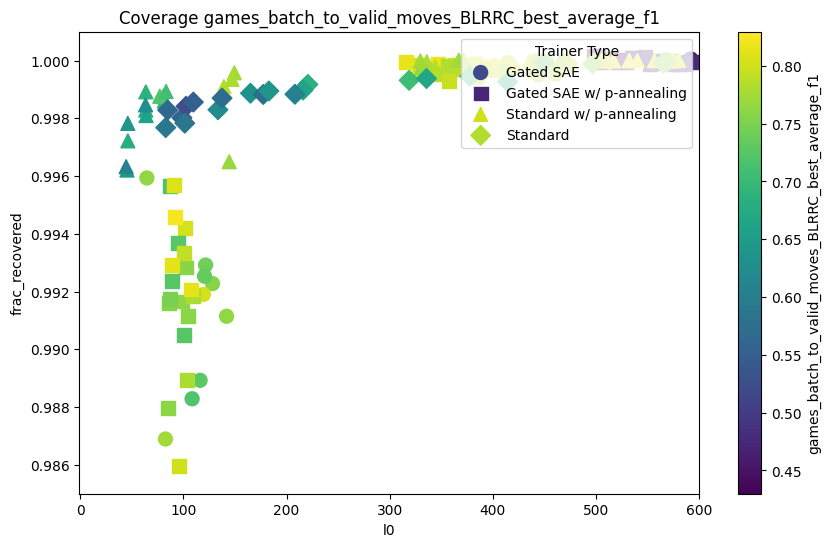

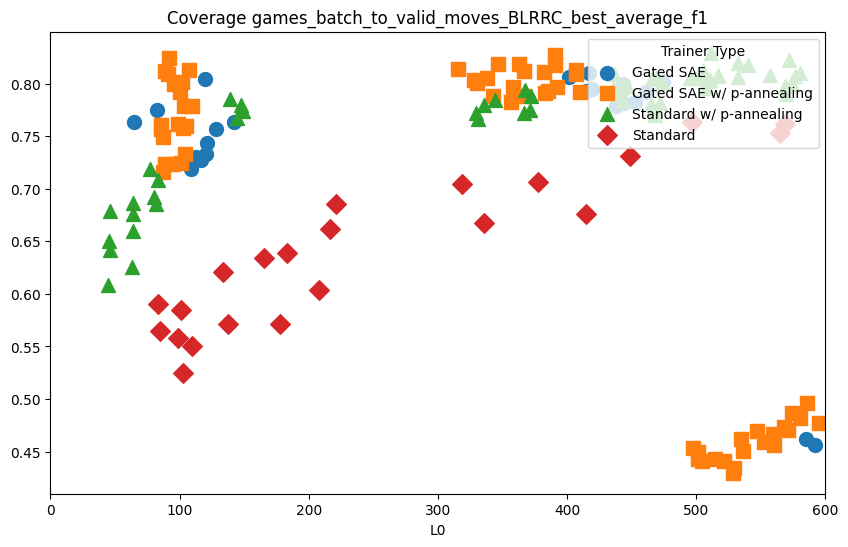

In [182]:
for i, column_name in enumerate(average_coverage_columns):
    idx_column_name = average_coverage_idx_columns[i]
    plot_3var_graph(column_name, idx_column_name, full_title=f"Coverage {column_name}")
    plot_l0_metric(column_name, full_title=f"Coverage {column_name}")

In [183]:
# for i, column_name in enumerate(average_metric_columns):
#     idx_column_name = average_metric_idx_columns[i]
#     plot_custom_metric(column_name, idx_column_name)

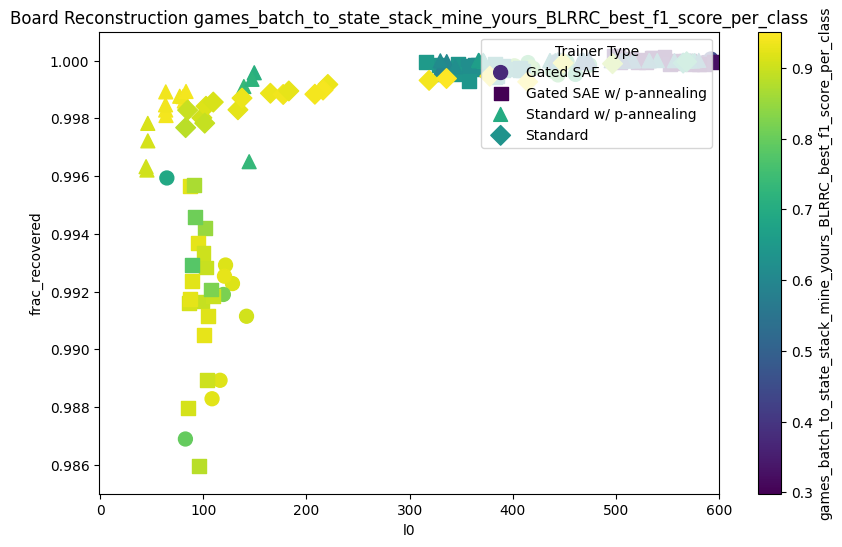

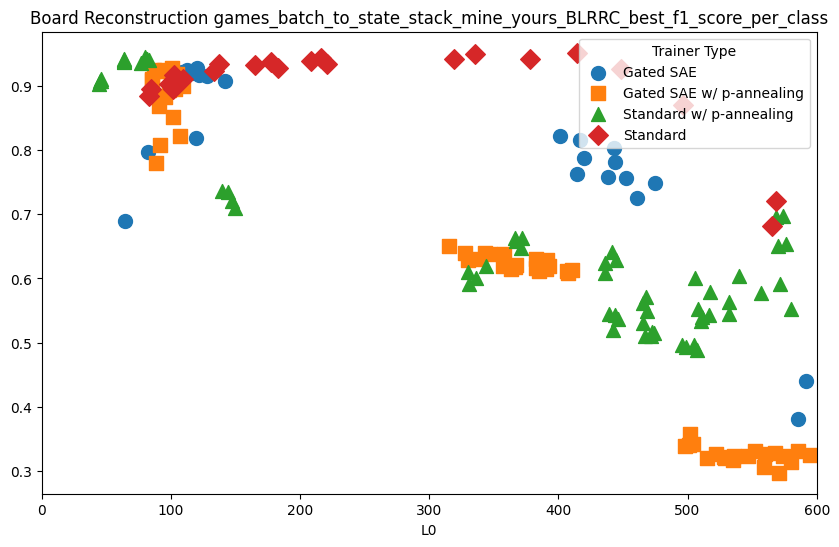

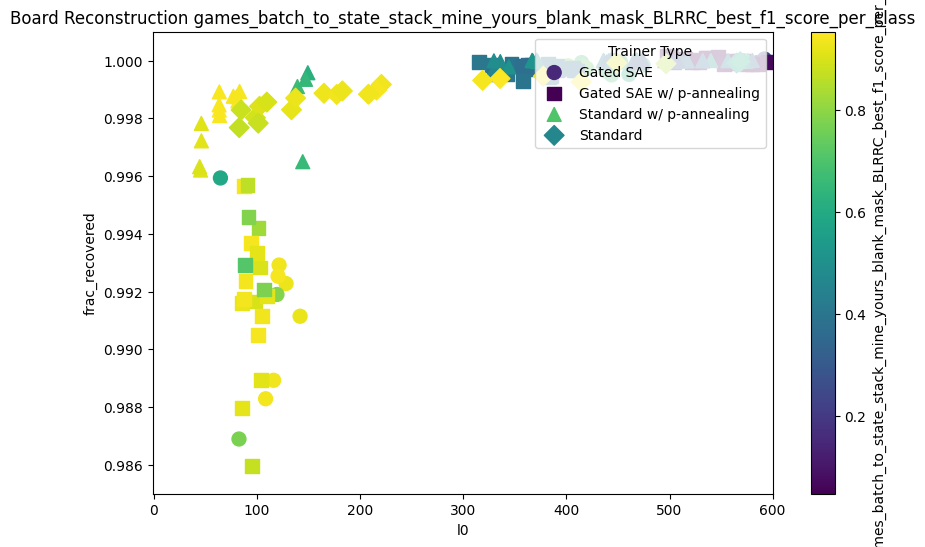

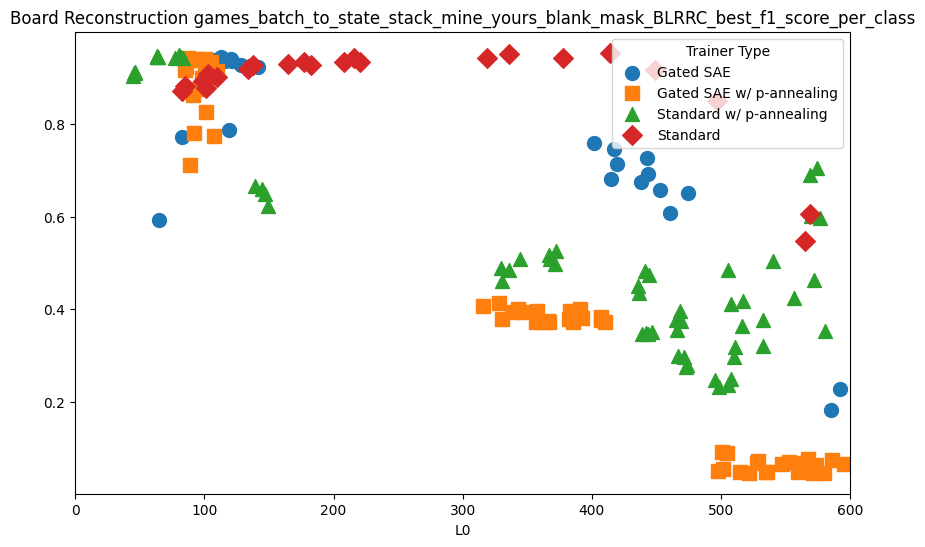

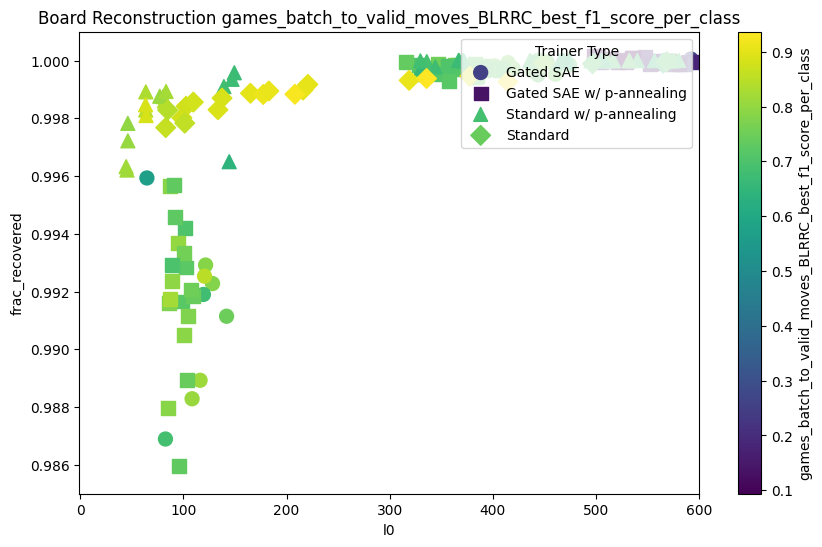

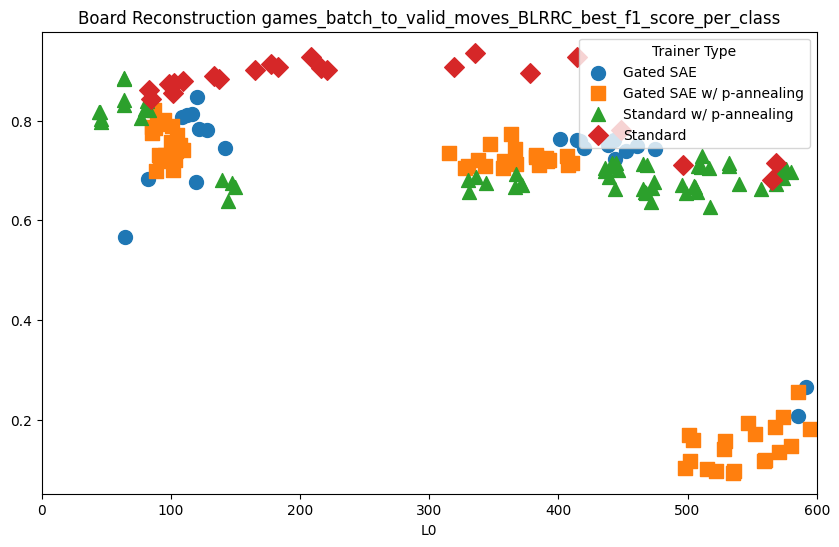

In [184]:
for i, column_name in enumerate(board_reconstruction_columns):
    idx_column_name = board_reconstruction_idx_columns[i]
    plot_3var_graph(column_name, idx_column_name, full_title=f"Board Reconstruction {column_name}")
    plot_l0_metric(column_name, full_title=f"Board Reconstruction {column_name}")

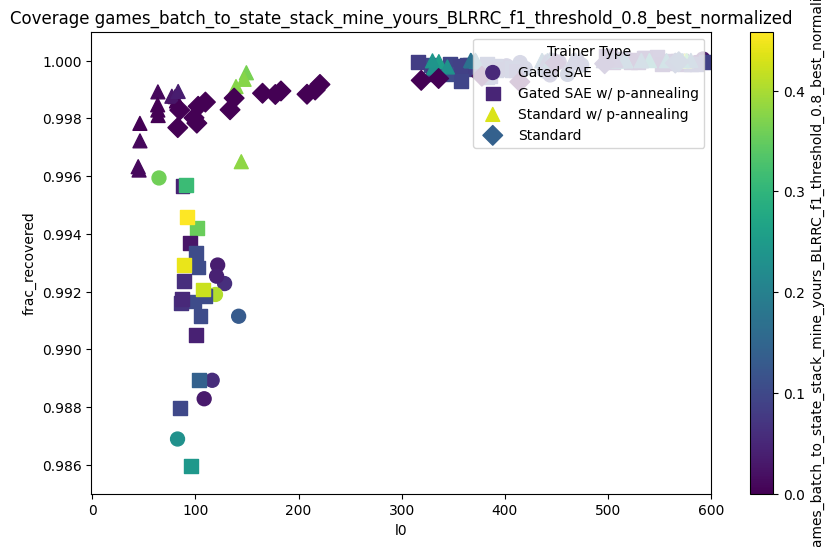

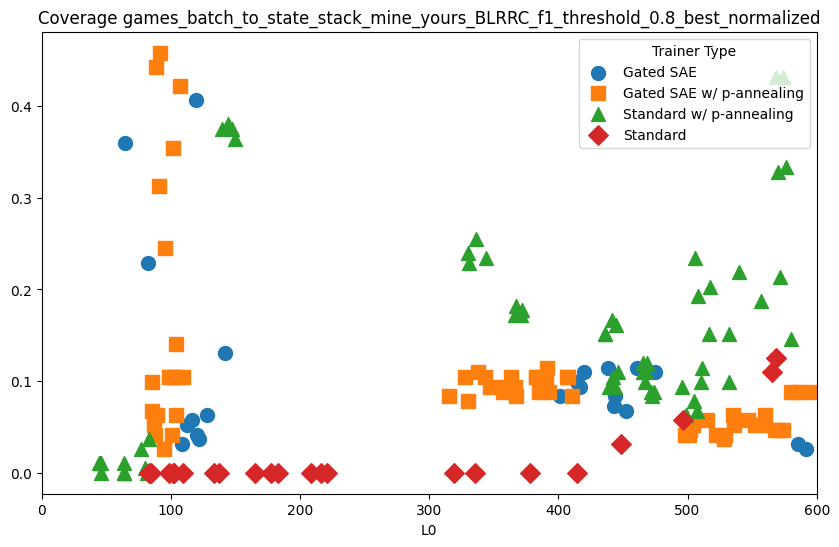

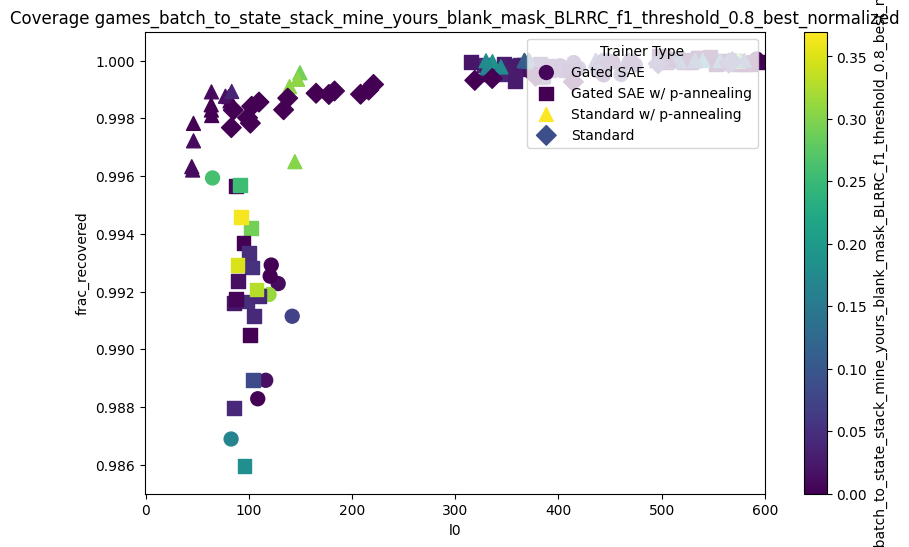

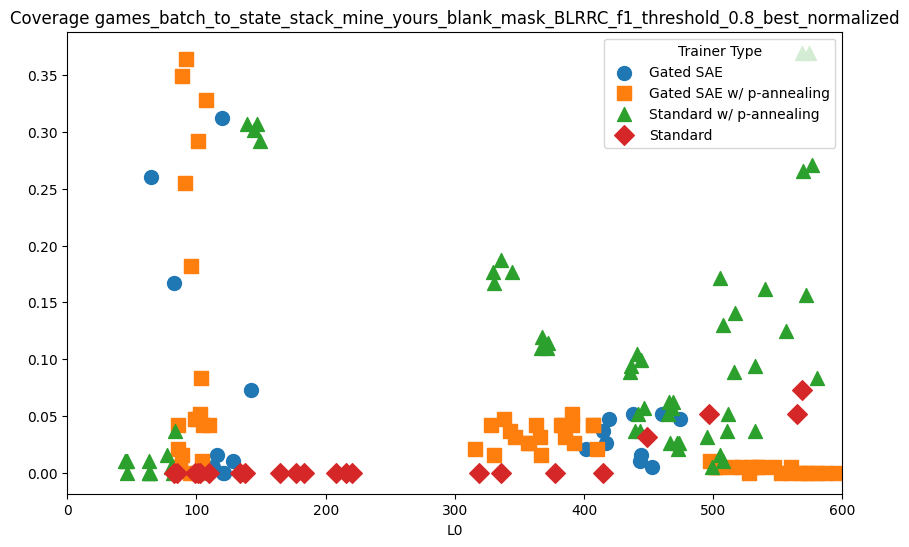

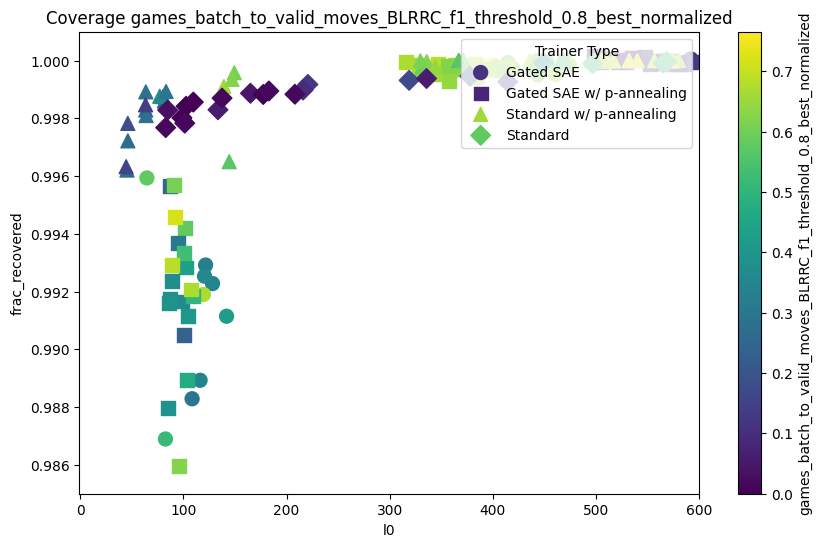

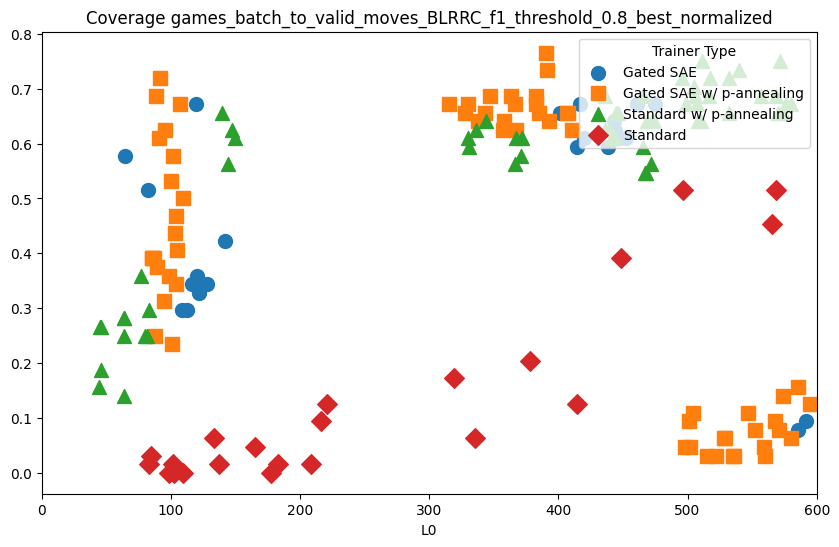

In [185]:
for i, column_name in enumerate(coverage_threshold_columns):
    idx_column_name = coverage_threshold_idx_columns[i]
    plot_3var_graph(column_name, idx_column_name, full_title=f"Coverage {column_name}")
    plot_l0_metric(column_name, full_title=f"Coverage {column_name}")

In [186]:
# for func_name in custom_function_names:

#     new_column_name = f"{func_name}_best_custom_metric"
#     if new_column_name not in df.columns:
#         df[new_column_name] = np.nan
    
#     second_column_name = f"{func_name}_best_custom_metric_idx"

#     f1_counter_T = all_sae_results[func_name]["f1_counter"]
#     best_idx = torch.argmax(f1_counter_T)

#     for autoencoder_group_path in autoencoder_group_paths:
#         folders = eval_sae.get_nested_folders(autoencoder_group_path)
        
#         for autoencoder_path in folders:
#             f1_T = all_sae_results[autoencoder_group_path][autoencoder_path][func_name]
#             best_f1 = f1_T[best_idx]
#             df.loc[df["autoencoder_path"] == autoencoder_path, new_column_name] = best_f1.item()
#             df.loc[df["autoencoder_path"] == autoencoder_path, second_column_name] = best_idx.item()